In [1]:
import torch
import numpy as np
from functools import partial
from tqdm import tqdm
import lib.utils.bookkeeping as bookkeeping
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
import torch.nn.functional as F
from lib.losses.losses import loss_fn
import os
from torch.utils.data import DataLoader
from lib.models.networks import MNISTScoreNet
import lib.utils.bookkeeping as bookkeeping
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from lib.config.config_bin_mnist import get_config 
from lib.datasets.datasets import create_train_discrete_mnist_dataloader, create_discrete_mnist_dataloader, get_binmnist_datasets
from lib.sampling.sampling import Euler_Maruyama_sampler
# Main file which contrains all DDSM logic
from lib.models.ddsm import *
#from lib.utils.utils import binary_to_onehot
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


/Users/paulheller/PythonRepositories/Master-Thesis/diffvenv/lib/python3.10/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/Users/paulheller/PythonRepositories/Master-Thesis/diffvenv/lib/python3.10/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details

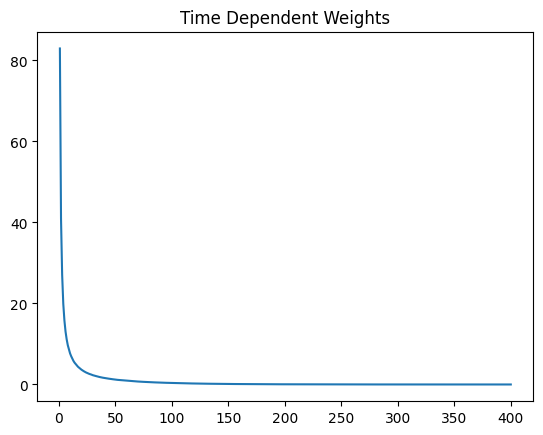

In [2]:
train_resume = False
if not train_resume:
    config = get_config()
    bookkeeping.save_config(config, config.saving.save_location)

else:
    path = '/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/DDSM/SavedModels/Bin_MNIST/'
    date = '2023-09-08'
    config_name = 'config_001.yaml'
    config_path = os.path.join(path, date, config_name)
    config = bookkeeping.load_config(config_path)

device = config.device

sb = UnitStickBreakingTransform()
v_one, v_zero, v_one_loggrad, v_zero_loggrad, timepoints = torch.load(config.loading.diffusion_weights_path)
v_one = v_one.cpu()
v_zero = v_zero.cpu()
v_one_loggrad = v_one_loggrad.cpu()
v_zero_loggrad = v_zero_loggrad.cpu()
timepoints = timepoints.cpu()

torch.set_default_dtype(torch.float32)
alpha = torch.ones(config.data.num_cat - 1).float()
beta =  torch.arange(config.data.num_cat - 1, 0, -1).float()


if config.use_fast_diff:
    diffuser_func = partial(diffusion_fast_flatdirichlet, noise_factory_one=v_one, v_one_loggrad=v_one_loggrad)
else: 
    diffuser_func = partial(diffusion_factory, noise_factory_one=v_one, noise_factory_zero=v_zero, noise_factory_one_loggrad=v_one_loggrad, noise_factory_zero_loggrad=v_zero_loggrad, alpha=alpha, beta=beta, device=config.device)


if config.speed_balanced:
    s = 2 / (torch.ones(config.data.num_cat - 1, device=config.device) + torch.arange(config.data.num_cat - 1, 0, -1,
                                                                                    device=config.device).float())
else:
    s = torch.ones(config.data.num_cat - 1, device=config.device)


train_set, valid_set, test_set = get_binmnist_datasets(config.loading.dataset_path) # torch.Size([64, 1, 28, 28])
train_dataloader = DataLoader(train_set, batch_size=config.data.batch_size, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_set, batch_size=config.data.batch_size, shuffle=False, num_workers=4)
valid_dataloader = None
test_dataloader = DataLoader(test_set, batch_size=config.data.batch_size, shuffle=True, num_workers=4)

time_dependent_weights = torch.load(config.loading.time_dep_weights_path)
plt.plot(np.arange(1, config.n_time_steps + 1), time_dependent_weights.cpu())
plt.title("Time Dependent Weights")
plt.show()


In [5]:
model = MNISTScoreNet(ch=config.model.ch, ch_mult=config.model.ch_mult, attn=config.model.attn, num_res_blocks=config.model.num_res_blocks, dropout=0.1, time_dependent_weights=time_dependent_weights)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))
optimizer = Adam(model.parameters(), lr=config.optimizer.lr, weight_decay=config.optimizer.weight_decay)
n_iter = 0
state = {"model": model, "optimizer": optimizer, "n_iter": 0}

if train_resume:
    checkpoint_path = config.saving.checkpoint_path
    model_name = 'model_32999.pt'
    checkpoint_path = os.path.join(path, date, model_name)
    state = bookkeeping.load_state(state, checkpoint_path)
    config.training.n_iter = 36000
    config.sampler.sample_freq = 36000
    config.saving.checkpoint_freq = 1000
    
sampler = Euler_Maruyama_sampler

number of parameters:  1619586


In [4]:
while True:
# epochen umrechnen in n_iter => epoch = 20 and dataset 10000 => n_iter = 20 * 10000
    avg_loss = 0.
    num_items = 0
    exit_flag = False

    #stime = time.time()

    for x_train in tqdm(train_dataloader, desc='Training'):
        #print("before:", x_train.shape)
        #print("squeeze", x_train.squeeze().long().shape)
        #x_train = binary_to_onehot(x_train.squeeze())
        x_train = F.one_hot(x_train.squeeze().long(), num_classes=config.data.num_cat)
        #print("after", x_train.shape)

        # Optional : there are several options for importance sampling here. it needs to match the loss function
        random_t = torch.LongTensor(np.random.choice(np.arange(config.n_time_steps), size=x_train.shape[0],
                                                    p=(torch.sqrt(time_dependent_weights) / torch.sqrt(
                                                        time_dependent_weights).sum()).cpu().detach().numpy()))
        # noise data
        """
        if self.config.random_order:
            order = np.random.permutation(np.arange(self.config.data.num_cat))
            # perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x[...,order], random_t, v_one, v_one_loggrad)
            #perturbed_x, perturbed_x_grad = diffusion_factory(x[..., order], random_t, v_one, v_zero, v_one_loggrad, v_zero_loggrad, alpha, beta) used diffusion facoty
            perturbed_x, perturbed_x_grad = self.diffuser_func(x=x_train[..., order], time_ind=random_t)

            perturbed_x = perturbed_x[..., np.argsort(order)]
            perturbed_x_grad = perturbed_x_grad[..., np.argsort(order)]
        else:
        """
        perturbed_x, perturbed_x_grad = diffuser_func(x=x_train.cpu(), time_ind=random_t) # used this: Flat dirichlet
        # perturbed_x, perturbed_x_grad = diffusion_factory(x, random_t, v_one, v_zero, v_one_loggrad, v_zero_loggrad, alpha, beta)

        perturbed_x = perturbed_x.to(config.device)
        perturbed_x_grad = perturbed_x_grad.to(config.device)
        random_timepoints = timepoints[random_t].to(config.device)

        random_t = random_t.to(config.device)

        # änderung hier kein cat x, s
        # predict noise?
        score = state['model'](perturbed_x, random_timepoints)

        # the loss weighting function may change, there are a few options that we will experiment o
        """
        if self.config.random_order:
            order = np.random.permutation(np.arange(self.config.data.num_cat))
            perturbed_v = self.sb._inverse(perturbed_x[..., order], prevent_nan=True).detach()
            loss = torch.mean(torch.mean(
                1 / (torch.sqrt(time_dependent_weights))[random_t][(...,) + (None,) * (x_train.ndim - 1)] * self.s[
                    (None,) * (x_train.ndim - 1)] * perturbed_v * (1 - perturbed_v) * (
                            gx_to_gv(score[..., order], perturbed_x[..., order], create_graph=True) - gx_to_gv(
                        perturbed_x_grad[..., order], perturbed_x[..., order])) ** 2, dim=(1)))
        else:
        """
        perturbed_v = sb._inverse(perturbed_x, prevent_nan=True).detach()
        loss = torch.mean(torch.mean(
            1 / (torch.sqrt(time_dependent_weights))[random_t][(...,) + (None,) * (x_train.ndim - 1)] * s[
                (None,) * (x_train.ndim - 1)] * perturbed_v * (1 - perturbed_v) * (
                        gx_to_gv(score, perturbed_x, create_graph=True) - gx_to_gv(perturbed_x_grad, perturbed_x)) ** 2, dim=(1)))
        #loss = loss_fn(x_train, perturbed_x, perturbed_x_grad, perturbed_v, score, self.s, important_sampling_weights=time_dependent_weights)
        
        state['optimizer'].zero_grad()
        loss.backward()
        state['optimizer'].step()
        avg_loss += loss.item() * x_train.shape[0]
        num_items += x_train.shape[0]
        #print("Loss:", loss.item())

        if (valid_dataloader is not None) and ((state['n_iter'] + 1) % config.training.validation_freq == 0): # 5 => 5 * n_iter
            state['model'].eval()
            valid_avg_loss = 0.0
            valid_num_items = 0
            
            #with torch.no_grad():
            print("Validation:")
            for x_valid in tqdm(valid_dataloader, desc='Validation'):
                
                x_valid = F.one_hot(x_valid.squeeze().long(), num_classes=config.data.num_cat)
                random_t = torch.LongTensor(np.random.choice(np.arange(config.n_time_steps),size=x_valid.shape[0],p=(torch.sqrt(time_dependent_weights) / torch.sqrt(time_dependent_weights).sum()).cpu().detach().numpy())).to(device)
                
                perturbed_x, perturbed_x_grad = diffuser_func(x_valid, random_t)
                # perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x, random_t, v_one, v_one_loggrad)
                
                perturbed_x = perturbed_x.to(device)
                perturbed_x_grad = perturbed_x_grad.to(device)
                random_t = random_t.to(device)
                random_timepoints = timepoints[random_t]

                score = state['model'](perturbed_x, random_timepoints)            
                perturbed_v = sb._inverse(perturbed_x, prevent_nan=True).detach()
                val_loss = torch.mean(torch.mean(1 / (torch.sqrt(time_dependent_weights))[random_t][(...,) + (None,) * (x_valid.ndim - 1)] * s[(None,) * (x_valid.ndim - 1)] * perturbed_v * (1 - perturbed_v) * (gx_to_gv(score, perturbed_x, create_graph=True) - gx_to_gv(perturbed_x_grad, perturbed_x)) ** 2, dim=(1)))
                #val_loss = loss_fn(x_valid, perturbed_x, perturbed_x_grad, perturbed_v, score, self.s, important_sampling_weights=time_dependent_weights)
                valid_avg_loss += val_loss.item() * x_valid.shape[0]
                valid_num_items += x_valid.shape[0]

            print("Average Validation Loss", valid_avg_loss / valid_num_items)
            state['model'].train()

        if (state['n_iter'] + 1) % config.sampler.sampler_freq == 0 or state['n_iter'] ==  config.training.n_iter- 1: 
            state['model'].eval()
            print("Sampling:")
            samples =sampler(state['model'], config.data.shape, batch_size=config.sampler.n_samples, max_time=4, min_time=0.01, num_steps=100, eps=1e-5, random_order=config.random_order, speed_balanced=config.speed_balanced, device=config.device)
            # (28, 28, 2)
            ## Sample visualization.
            print("samples before", samples, samples.shape)
            samples = samples.clamp(0.0, config.data.num_cat)
            print("samples after", samples, samples.shape)
            sample_grid = make_grid(samples[:,None, :,:,0].detach().cpu(), nrow=int(np.sqrt(config.sampler.n_samples)))

            # plot 
            plt.figure(figsize=(6,6))
            plt.axis('off')
            plt.imshow(sample_grid.permute(1, 2, 0).cpu())
            #plt.show()
            # save
            saving_plot_path = os.path.join(config.saving.sample_plot_path, f"samples_epoch_{state['n_iter']}.png")
            plt.savefig(saving_plot_path)
            plt.close()
            
            state['model'].train()

        if (state['n_iter'] + 1) % config.saving.checkpoint_freq == 0 or state['n_iter']== config.training.n_iter - 1:
            bookkeeping.save_state(state, config.saving.save_location)

        if config.training.n_iter == state['n_iter'] - 1:
            exit_flag = True
            break

        state['n_iter'] += 1

    print("Average Loss after 1 epoch:", avg_loss / num_items)
    if exit_flag:
        break
                



Training:   0%|          | 0/938 [00:00<?, ?it/s]/Users/paulheller/PythonRepositories/Master-Thesis/diffvenv/lib/python3.10/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/Users/paulheller/PythonRepositories/Master-Thesis/diffvenv/lib/python3.10/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mo

Sampling:


Sampling: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


samples before tensor([[[[8.8722e-01, 1.1278e-01],
          [9.5687e-01, 4.3125e-02],
          [3.5610e-01, 6.4390e-01],
          ...,
          [6.0482e-01, 3.9518e-01],
          [7.5754e-01, 2.4246e-01],
          [5.4586e-01, 4.5414e-01]],

         [[2.2288e-01, 7.7712e-01],
          [8.9637e-01, 1.0363e-01],
          [8.3160e-01, 1.6840e-01],
          ...,
          [9.8004e-01, 1.9956e-02],
          [4.7542e-01, 5.2458e-01],
          [4.8738e-02, 9.5126e-01]],

         [[5.9091e-01, 4.0909e-01],
          [9.0302e-01, 9.6984e-02],
          [7.7946e-01, 2.2054e-01],
          ...,
          [9.2849e-01, 7.1514e-02],
          [8.9635e-01, 1.0365e-01],
          [2.4241e-01, 7.5759e-01]],

         ...,

         [[9.7179e-01, 2.8211e-02],
          [9.8005e-01, 1.9945e-02],
          [9.9999e-01, 1.0014e-05],
          ...,
          [9.9016e-01, 9.8448e-03],
          [9.3022e-01, 6.9777e-02],
          [8.2796e-01, 1.7204e-01]],

         [[9.6485e-01, 3.5146e-02],
  

Training:   1%|          | 11/938 [02:34<3:36:49, 14.03s/it]

Average Loss after 1 epoch: 3.6207918326059976
